In [ ]:
import os

!apt-get -qq -y install fonts-nanum
os.kill(os.getpid(), 9)

Selecting previously unselected package fonts-nanum.
(Reading database ... 120882 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
from scipy import stats
from tqdm import tqdm
from bs4 import BeautifulSoup
from transformers import pipeline
import os
import re
import datetime
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
fm.fontManager.ttflist.insert(0, fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', name='NanumGothic'))
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 수집, 가공, 정제

##1.1 증권별 네이버 증권 뉴스 크롤링

In [3]:
# 종목 이름을 입력했다면 코드로 변환하는 함수
def convert_input_to_code(input_text, stock_data):
    pattern = '[a-zA-Z가-힣]+'
    if bool(re.match(pattern, input_text)):
        stock_code = stock_data.loc[stock_data['회사명'] == input_text, '종목코드'].values[0]
    else:
        stock_code = str(input_text)
    return f'{stock_code:0>6}'

# 크롤링 후 csv 저장 함수
def crawl_and_save_news(company_code, start_date):
    page = 1

    with tqdm(desc='진행 중', unit='페이지') as pbar:         # tqdm을 이용해 진행상황 표시
        while True:
            date_result, source_result, title_result = [], [], []

            url = f'https://finance.naver.com/item/news_news.nhn?code={company_code}&page={page}'
            response = requests.get(url)

            # 응답 코드가 200이 아닌경우 오류 출력
            if response.status_code != 200:
                print(f"Failed to fetch data from {url}. Status code: {response.status_code}")
                return None

            soup = BeautifulSoup(response.text, 'html.parser')
            news_table = soup.find('table', class_='type5')
            news_rows = news_table.find_all('tr')

            for idx, row in enumerate(news_rows):
                # 관련 뉴스는 제외
                if idx == 0:
                    continue
                if "class" in row.attrs and "relation_lst" in row["class"]:
                    continue
                if row.find_parent("tr", class_="relation_lst"):
                    continue

                # 제목, 언론사, 날짜 텍스트 추출
                title = row.find('td', class_='title').text.strip()
                info = row.find('td', class_='info').text.strip()
                date = row.find('td', class_='date').text.strip()

                # 날짜 텍스트를 날짜 데이터로 변환
                news_date = datetime.datetime.strptime(date, '%Y.%m.%d %H:%M')

                # 사용자가 지정한 날짜와 가져온 뉴스의 날짜를 비교
                if news_date >= start_date:
                    date_result.append(news_date)
                    source_result.append(info)
                    title_result.append(title)
                else:
                    # 만약 시작 날짜보다 더 전인경우, 크롤링 중단
                    break

            # 사용자가 지정한 날짜 이후의 뉴스가 없는경우 중단
            if not date_result:
                break

            result = {"Date": date_result, "Media": source_result, "Title": title_result}
            df_result = pd.DataFrame(result)

            # 첫페이지만 헤더를 적용
            mode = 'w' if page == 1 else 'a'
            header = page == 1

            # 결과를 csv파일로 저장
            df_result.to_csv(
                f"{company_code}_news.csv",
                mode=mode,
                encoding='utf-8-sig',
                header=header,
                index=False
            )

            pbar.update(1)
            page += 1

    return f"{company_code}_news.csv"

In [4]:
# 종목 데이터(종목이름, 종목코드) 불러오기
stock_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
stock_data = stock_data.iloc[:, :2]

# 사용자 입력(종목, 날짜)
#input_text = input('종목코드 또는 종목이름을 입력: ')
#input_date = input('크롤링을 시작할 날짜 입력 (YYYYMMDD): ')
input_text = "005930"
input_date = "20230921"
start_date = datetime.datetime.strptime(input_date, "%Y%m%d")

# 사용자 입력 종목 -> 코드 변환
stock_code = convert_input_to_code(input_text, stock_data)

# 크롤링 후 데이터 저장
file_path = crawl_and_save_news(stock_code, start_date)

if file_path:
    print(f"\n{file_path}에 저장되었습니다.")
else:
    print("\n크롤링 작업이 실패했습니다.")

진행 중: 388페이지 [05:13,  1.24페이지/s]


005930_news.csv에 저장되었습니다.


##1.2 날자별 종목 지수 데이터 수집

[*********************100%%**********************]  1 of 1 completed


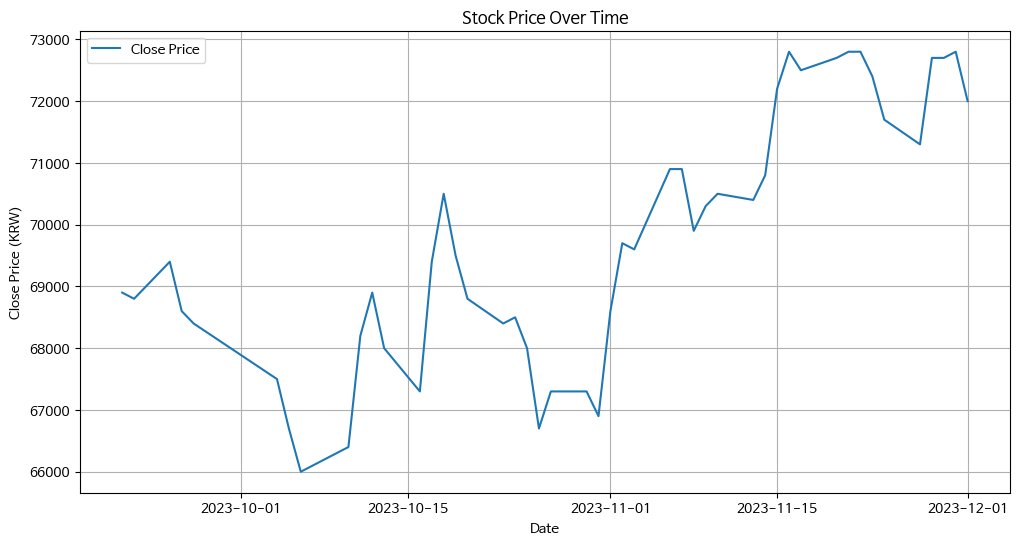

In [8]:
# 야후 Finace에서 종목 지수 데이터 수집
stock_df = yf.download(stock_code + ".KS", start=start_date.strftime("%Y-%m-%d"), end=datetime.datetime.today())

# 날짜별 종가 추이
plt.figure(figsize=(12, 6))
plt.plot(stock_df['Close'], label='Close Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.show()

#2. 뉴스 기사 감정 분석

##2.1 감정분석 모델을 이용한 뉴스 분류

In [9]:
# KR-FinBert-SC 금융 뉴스 분석 모델(서울대학교 컴퓨터언어학_자연어처리 연구실 개발)을 이용한 감정 분석
sentiment_pipe = pipeline(model='snunlp/KR-FinBert-SC')

# 뉴스 데이터 읽어오기
news_df = pd.read_csv(file_path)
headline = news_df['Title'].tolist()

# 감정 분석 실행
senti_result_df = pd.DataFrame(sentiment_pipe(headline))
news_df['Senti'] = senti_result_df['label']
news_df['Score'] = senti_result_df['score']

config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/406M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/143k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/294k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

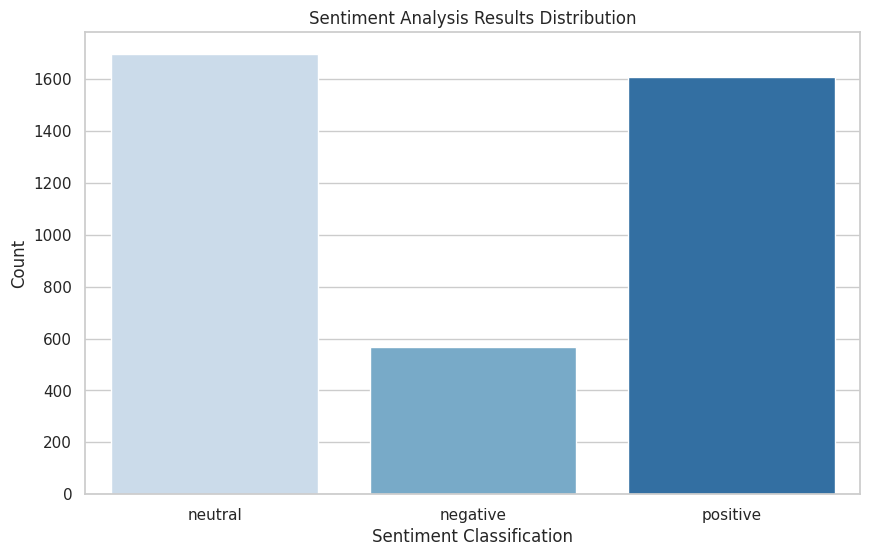

In [10]:
# 긍정, 부정, 중립으로 분석된 결과의 분포 시각화
sns.set_theme(font='NanumGothic')
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x='Senti', data=news_df, palette='Blues')
plt.title('Sentiment Analysis Results Distribution')
plt.xlabel('Sentiment Classification')
plt.ylabel('Count')
plt.show()

##2.2 감정분류 계량화
positive, neutral, negative로 구분된 감정 분류를 데이터 분석을 위해 숫자 형식으로 계량화 작업 진행

In [11]:
def str_to_num(x):
    if x == 'positive' :
        return 3
    elif x == 'neutral' :
        return 2
    elif x == 'negative' :
        return 1
    else :
        return -1

news_df['Total_score'] = news_df['Senti'].apply(lambda x : str_to_num(x)) + news_df['Score']
news_df

,Date,Media,Title,Senti,Score,Total_score
0,2023-12-03 15:53:00,매일경제,여러 ‘썰’ 많았던 삼성 인사…뚜껑 막상 열어보니 [방영덕의 디테일],neutral,0.999773,2.999773
1,2023-12-03 14:58:00,매일경제,‘서학개미 순매수 1위’는 SOXL…미·중 반도체 갈등 속 외인은 삼전...,negative,0.933351,1.933351
2,2023-12-03 14:38:00,이코노미스트,"외국인, 11월 삼성전자 2조 순매수…4개월 만에 ‘사자’ 전환",positive,0.607646,3.607646
3,2023-12-03 13:51:00,파이낸셜뉴스,"10주년 삼성웰스토리 해외영토 늘린다..""글로벌 식음 솔루션 리더될 것...",neutral,0.999798,2.999798
4,2023-12-03 13:29:00,조선비즈,"삼성, 美·中 제치고 ‘청색 양자점’ 특허 세계 1위… 차세대 디스플레...",positive,0.999804,3.999804
...,...,...,...,...,...,...
3868,2023-09-21 00:06:00,매일경제,"삼성스토어, '삼성스토어' 바뀐 새 이름으로 선봬",neutral,0.993524,2.993524
3869,2023-09-21 09:06:00,뉴시스,"삼성전자, 美소비자 만족도 PC부문 공동 1위",positive,0.999766,3.999766
3870,2023-09-21 08:41:00,서울경제,"쫓아오는 인텔 파운드리…삼성, 2025년 2나노 이하 '승부수' [bi...",positive,0.928360,3.928360
3871,2023-09-21 06:31:00,뉴시스,"삼성전자·SK하이닉스, 역대급 불황에 추석 상여금은?",neutral,0.999550,2.999550


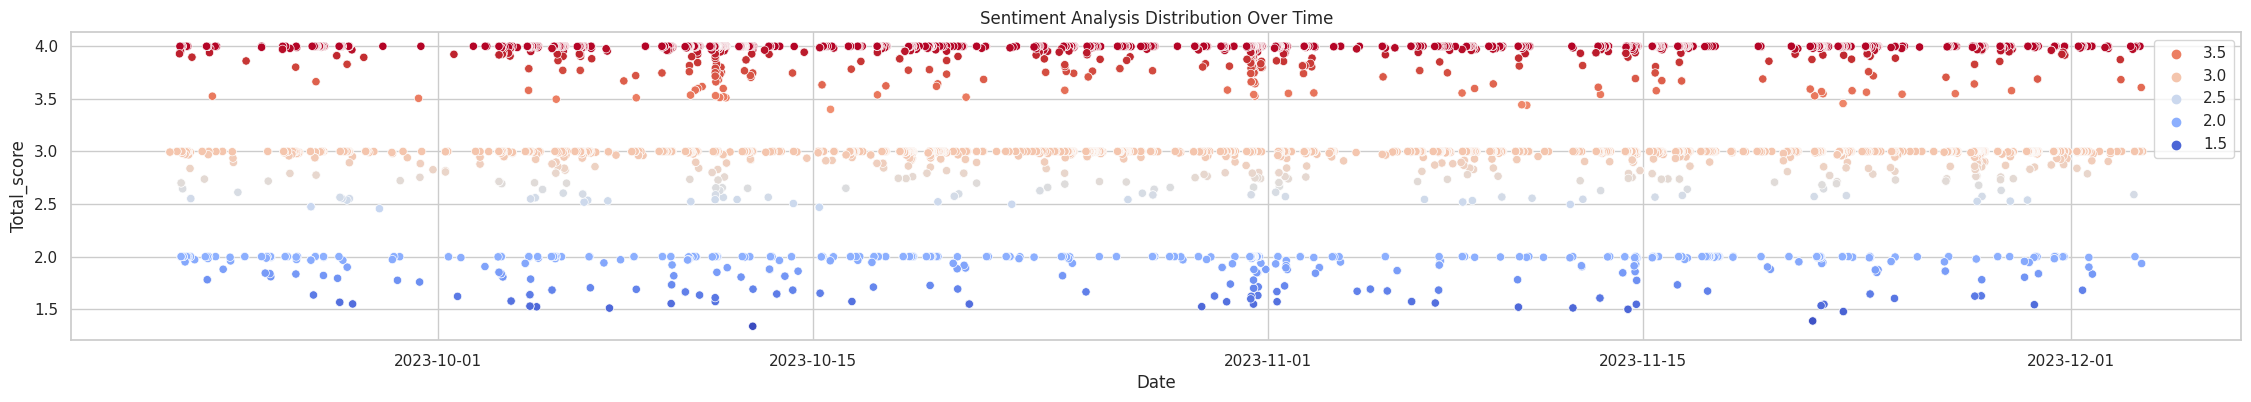

In [12]:
# 계량화 한 감성 점수를 날짜별로 시각화
plt.figure(figsize=(28,4))
sns.scatterplot(x=pd.to_datetime(news_df['Date']), y=news_df['Total_score'], hue=news_df['Total_score'], palette='coolwarm')
plt.title('Sentiment Analysis Distribution Over Time')
plt.legend(reverse=True)
plt.show()

#3. 상관성 분석
뉴스 데이터와 주식 데이터간의 상관관계 분석을 위해 다음과 같은 단계를 따랐다.
1. 두 데이터들의 Date열을 datetime 형식으로 변환하고 두 datetime 형식을 같은 형식으로 맞춘다음 합친다.
2. 주가 데이터를 log변환한후 차분하고 감정 점수와 같이 min-max-scailing 방식으로 정규화 한뒤 0.5를 빼서 음과 양을 표현할 수 있도록 했다.
3. 상관분표 표를 통해 일별, 주별 감성 점수와 주식 데이터간의 상관관계를 나타냈다.

In [13]:
# 날짜 데이터를 datetime 형식으로 변환
news_df['Date'] = pd.to_datetime(news_df['Date']).dt.date  # 연-월-일 시:분 -> 연-월-일
news_df.set_index('Date', inplace=True)                    # Date를 index 지정
stock_df.index = pd.to_datetime(stock_df.index).date       # stock_df를 날짜 부분만 가지도록 변환

# 두 데이터프레임을 합침
merged_df = pd.merge(news_df, stock_df, left_index=True, right_index=True)
merged_df.to_csv('df_final.csv', encoding='utf-8-sig')

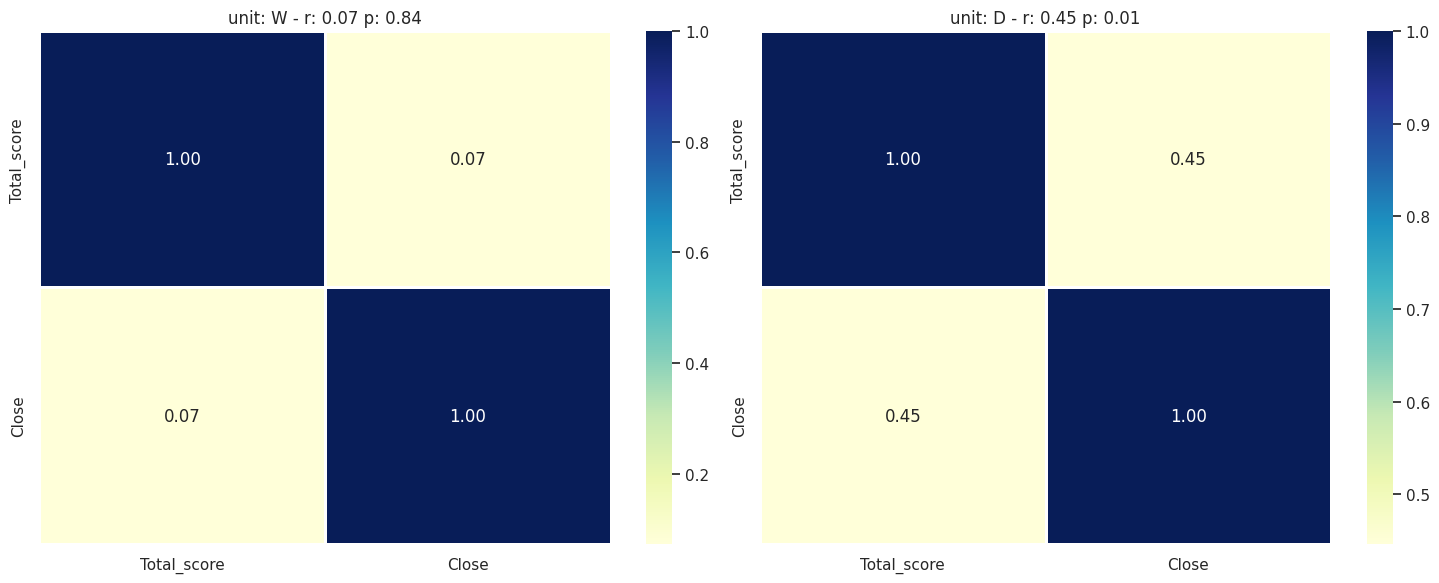

In [16]:
df = merged_df
df.index = pd.to_datetime(df.index)         # index를 datetime 형식으로 변환

# correlation heatmap을 표시하는 함수
def show_target_corr(df, unit, ax, i):
    data = df.resample(unit)['Close'].mean()

    scaled_target = np.log(data).diff()         # 로그 변환후 차분
    scaled_target = (scaled_target - scaled_target.min()) / (scaled_target.max() - scaled_target.min()) - 0.5         # 정규화 후 음과 양 표현을 위해 0.5 빼기
    resampled_target = scaled_target.resample(unit).mean()
    resampled_target.index = resampled_target.index.strftime('%Y-%m-%d')

    scaled_score = (df['Total_score'] - df['Total_score'].min()) / (df['Total_score'].max() - df['Total_score'].min()) - 0.5        # 정규화 후 0.5빼기
    resampled_score = scaled_score.resample(unit).mean()
    resampled_score.index = resampled_score.index.strftime('%Y-%m-%d')

    resampled_df = pd.merge(left=resampled_score, right=resampled_target, left_index=True, right_index=True, how='inner').dropna()

    sns.heatmap(resampled_df.corr(), linecolor='w', linewidth=1, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax[i])
    s = stats.pearsonr(resampled_df['Total_score'], resampled_df['Close'])
    ax[i].set_title(f'unit: {unit} - r: {s[0]:.2f} p: {s[1]:.2f}')      # plot의 타이틀
    plt.tight_layout()

# 한 행에 두 개의 plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Correlation Heatmap 그리는 함수 호출
show_target_corr(df, 'W', ax, 0)        # 주별 상관관계 분석
show_target_corr(df, 'D', ax, 1)        # 일별 상관관계 분석

plt.show()

# Reference

김유신, 김남규, 정승렬. (2012). 뉴스와 주가 : 빅데이터 감성분석을 통한 지능형 투자의사결정모형. 지능정보연구, 18(2), 143-156.

이예지. "뉴스 빅데이터 분석을 통한 종목별 주가예측." 국내석사학위논문 충북대학교, 2014. 충청북도

https://songseungwon.tistory.com/124

https://github.com/CSJ516/Stock_Prediction_project

https://github.com/seyoongit/news

https://github.com/park-gb/financial-news-sentiment-classifier/blob/main/sentiment_classifier.ipynb